# 0.0. IMPORTS

In [79]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import math
import numpy as np
import inflection
import seaborn as sns 
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from IPython.core.display import HTML

import datetime

## 0.1. Helper Functions

In [2]:
#Teste baseado em Pearson
def cramer_v(x,y):
    cm = pd.crosstab(x,y).to_numpy()    
    # Soma de tds os valores
    n = cm.sum()
    #Número de linhas e colunas
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    #Aplicando a correção de bies do cramer-v
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)

    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize']=[25,12]
    plt.rcParams['font.size']=24
    
    display(HTML('<style>.container{width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_options('display.expand_frame_repr', False)
    
    sns.set()

## 0.2. Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw , how='left', on='Store' )

# 1.0. DESCRICAO DOS DADOS 

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
767051,717,2,2013-08-13,6979,633,1,1,0,1,d,c,310.0,NaN,NaN,1,40.0,2011.0,"Jan,Apr,Jul,Oct"


In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Numero de colunas: {}'.format(df1.shape[0]))
print('Numero de colunas: {}'.format(df1.shape[1]))

Numero de colunas: 1017209
Numero de colunas: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
#competition_distance         
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1) 

#promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1) 

#promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1) 


#promo interval
month_map = {1: 'Jan',2:'Fev',3:'Mar',4:'Abr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Set', 10:'Out',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo']=df1[['promo_interval','month_map']].apply(lambda x:0 if x['promo_interval']== 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Type

In [12]:
#df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
#df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['competition_open_since_month'] = np.dtype('int64').type(df1['competition_open_since_month'])
df1['competition_open_since_year'] = np.dtype('int64').type(df1['competition_open_since_year'])


df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)



## 1.7. Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes(include=['int64','float64','int32'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]','int32'])

## 1.7.1 Numerical Attributes

In [14]:
# Tendencia Central - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersión - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x:x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

In [15]:
#Concatenar
m = pd.concat([d2,d3,d4,ct1,ct2,d5,d6]).T.reset_index()


In [16]:
m.columns=['Attributes','Min','Max','Mean','Median','std','skew','kurtosis']

In [17]:
m

,Attributes,Min,Max,Mean,Median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

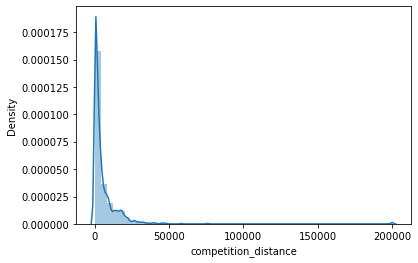

In [18]:
sns.distplot(df1['competition_distance'])

## 1.7.2. Categorical Attributes

In [19]:
#Conteo de valores únicos por cada attributo
cat_attributes.apply(lambda x:x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

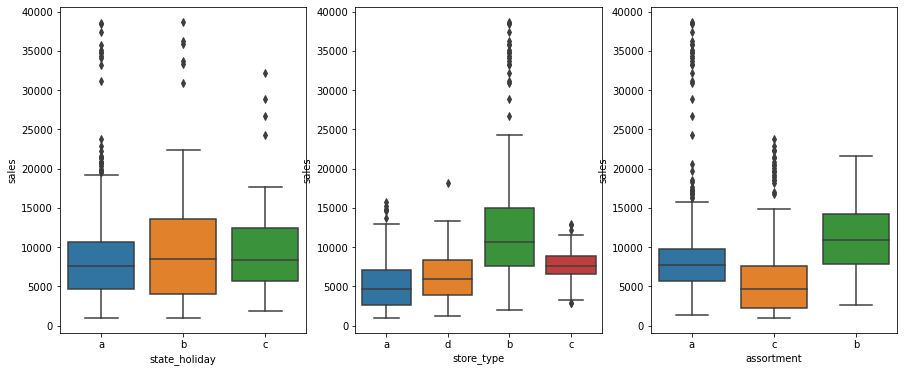

In [20]:
aux1=df1[(df1['state_holiday']!='0') & (df1['sales']>0)]
#a = feriado, b = Feriado de Páscoa, c = Natal

fig = plt.figure(figsize =(15, 6))

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# 2.0. FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

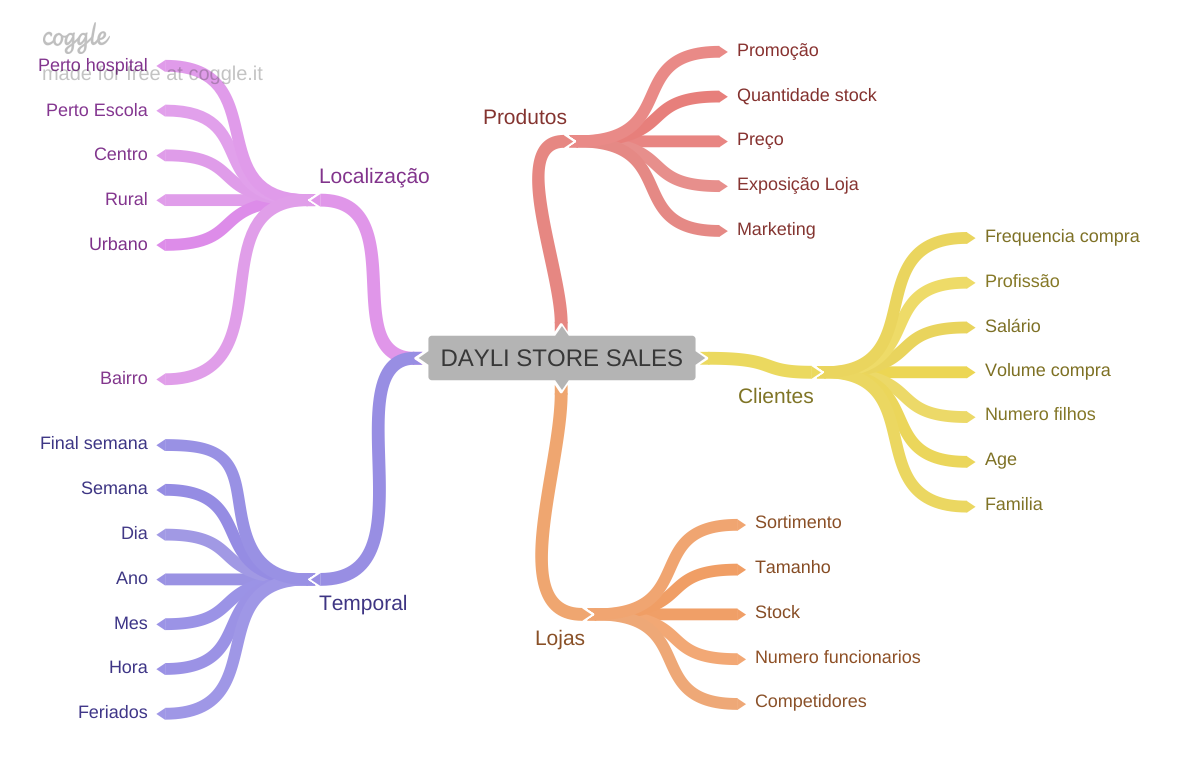

In [22]:
Image('img/DAYLI_STORE_SALES.png')

## 2.1.1. Hipoteses Lojas

**1.** Lojas com maior número de funcionários deveriam vender mais <br>
**2.** Lojas com maior capacidade de estoque deveriam vender mais <br>
**3.** Lojas com maior porte deveriam vender mais <br>
**4.** Lojas com maior sortimento deveriam vender mais <br>
**5.** Lojas com competidores mais perto deveriam vender menos <br>
**6.** Lojas com competidores a mais tempo deveriam vender mais

## 2.1.2. Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais <br>
**2.** Lojas com maior exposição de produtos deveriam vender mais <br>
**3.** Lojas com produtos com preço menor deveriam vender mais <br>
**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais <br>
**5.** Lojas com promoções ativas por mais tempo deveriam vender mais <br>
**6.** Lojas com mais dias de promoção deveriam vender mais <br>
**7.** Lojas com mais promoções consecutivas deveriam vender mais

## 2.1.3. Hipóteses Tempo

**1.** Lojas abertas durante o periodo de natal deveriam vender menos <br>
**2.** Lojas deveriam vender mais ao longo dos anos <br>
**3.** Lojas deverian vender mais no segundo semestre do ano <br>
**4.** Lojas deveriam vender mais depois do dia 10 de cada mês <br>
**5.** Lojas deveriam vender menos nos finais de semana <br>
**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.2. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais <br>
**2.** Lojas com competidores mais perto deveriam vender menos <br>
**3.** Lojas com competidores a mais tempo deveriam vender mais <br>
**4.** Lojas com promoções ativas por mais tempo deveriam vender mais <br>
**5.** Lojas com mais dias de promoção deveriam vender mais <br>
**6.** Lojas com mais promoções consecutivas deveriam vender mais<br>
**7.** Lojas abertas durante o periodo de natal deveriam vender menos <br>
**8.** Lojas deveriam vender mais ao longo dos anos <br>
**9.** Lojas deverian vender mais no segundo semestre do ano <br>
**10.** Lojas deveriam vender mais depois do dia 10 de cada mês <br>
**11.** Lojas deveriam vender menos nos finais de semana <br>
**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.3. Feature Engineering

In [23]:
#Year
df2['year'] = df2['date'].dt.year

#Month
df2['month'] = df2['date'].dt.month

#Day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


#promo since
df2['promo_since']=df2['promo2_since_year'].astype(str) +'-'+ df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x:x.days).astype(int)

#competition since
#df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month=x['competition_open_since_month'], day=1))
#df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x:x.days).astype(int)

#assortments
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state holidays
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [24]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. FILTRAGEM DE VARIAVEIS

In [25]:
df3 = df2.copy()


In [26]:
# Para mostrar todas as colunas do dataset
pd.set_option('display.max_columns', None)
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-07-27,0


## 3.1. Filtragem de Linhas

In [27]:
df3 = df3[(df3['open']!=0) & (df3['sales']>0)]

## 3.2. Seleção de Colunas


In [28]:
cols_drop = ['customers', 'open','promo_interval','month_map']

In [29]:
df3 = df3.drop(cols_drop, axis=1)

In [30]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. ANALISE EXPLORATORIA DOS DADOS

In [31]:
df4 = df3.copy()

## 4.1. Analise Univariada

## 4.1.1. Variavel Resposta

<AxesSubplot:xlabel='sales', ylabel='Density'>

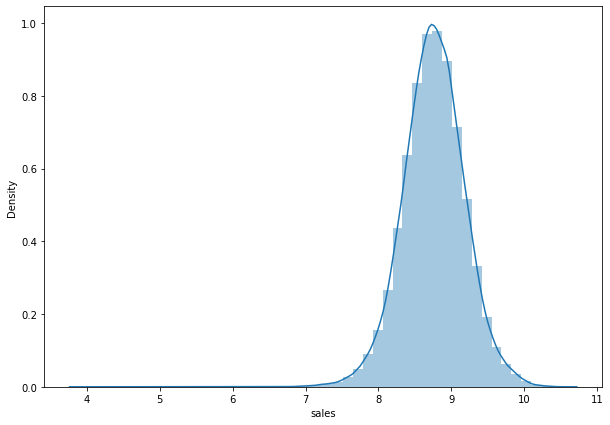

In [32]:
fig = plt.figure(figsize =(10, 7))
sns.distplot(np.log1p(df4['sales']))
# Aplicando transformação logaritmica
#Descobrir a distribuição dos dados, kurtosis. 

## 4.1.2. Variavel Numerica

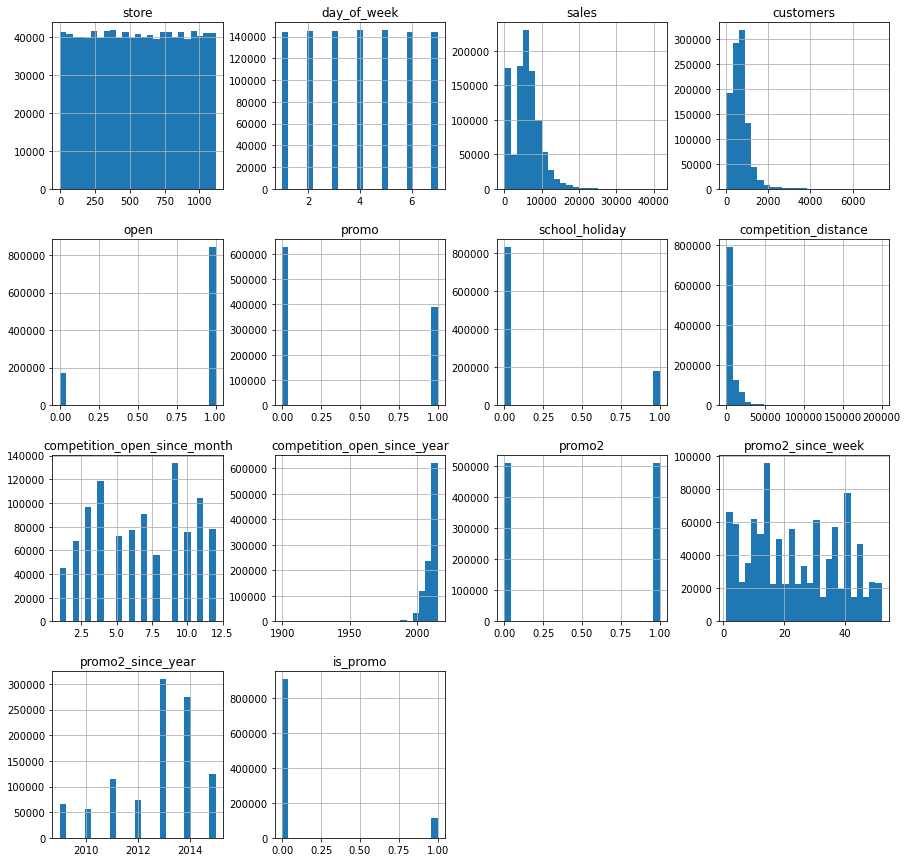

In [33]:
num_attributes.hist(figsize=(15, 15),bins = 25);

## 4.1.3. Variaveis Categóricas

In [34]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

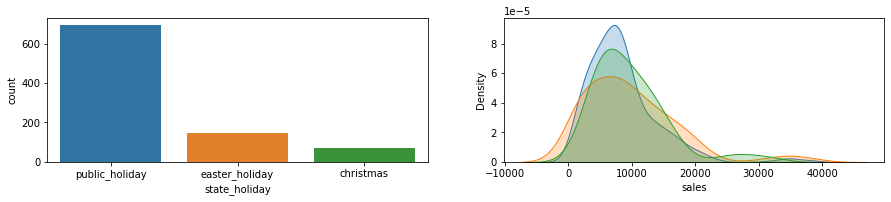

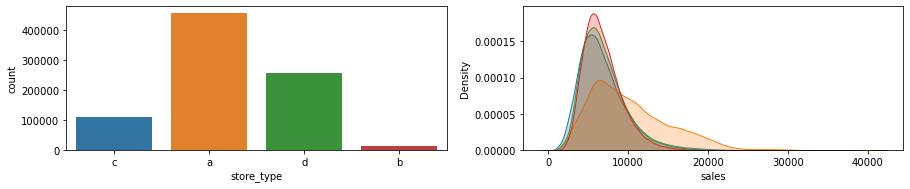

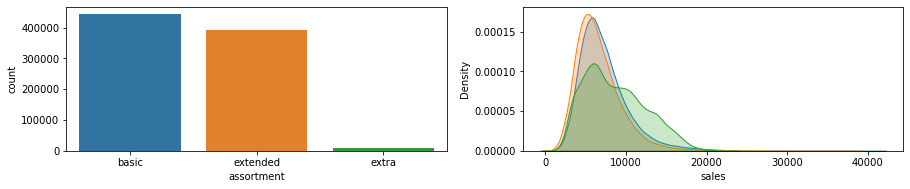

In [35]:
#State holiday
fig = plt.figure(figsize =(15, 9))

plt.subplot(3,2,1)
a = df4[df4['state_holiday']!= 'regular_day']

sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] =='public_holiday']['sales'],label='public_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] =='easter_holiday']['sales'],label='easter_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] =='christmas']['sales'],label='christmas',shade=True)

#Store_type
fig = plt.figure(figsize =(15, 9))

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] =='a']['sales'],label='a',shade=True)
sns.kdeplot(df4[df4['store_type'] =='b']['sales'],label='b',shade=True)
sns.kdeplot(df4[df4['store_type'] =='c']['sales'],label='c',shade=True)
sns.kdeplot(df4[df4['store_type'] =='d']['sales'],label='d',shade=True)

#Assortment
fig = plt.figure(figsize =(15, 9))

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] =='extended']['sales'],label='extended',shade=True)
sns.kdeplot(df4[df4['assortment'] =='basic']['sales'],label='basic',shade=True)
sns.kdeplot(df4[df4['assortment'] =='extra']['sales'],label='extra',shade=True)


## 4.2. Analise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais
**FALSO** Lojas com maior sortimento vendem menos!

In [36]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()

<AxesSubplot:xlabel='year_week'>

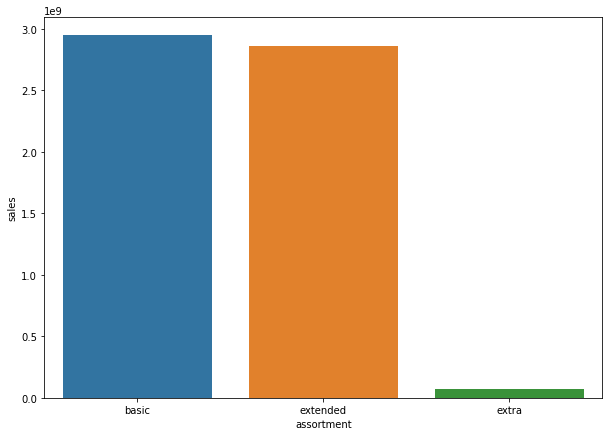

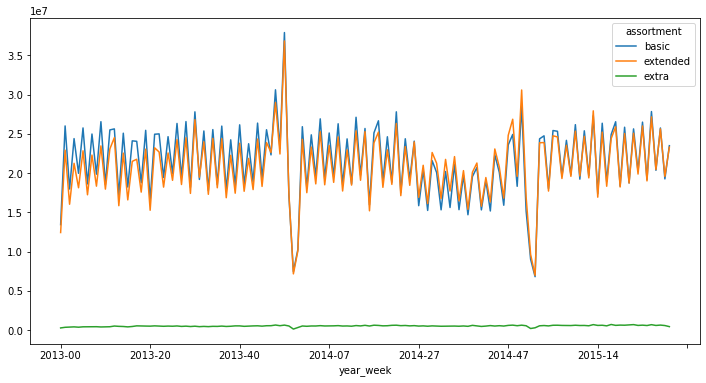

In [37]:
fig = plt.figure(figsize =(10, 7))
sns.barplot(x='assortment',y='sales',data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
#fig = plt.figure(figsize =(10, 7))
aux2.pivot(index='year_week',columns='assortment',values='sales').plot(figsize =(12, 6))

### H2. Lojas com competidores mais próximos deveriam vender menos
**FALSO** Lojas com competidores mais próximos vendem mais

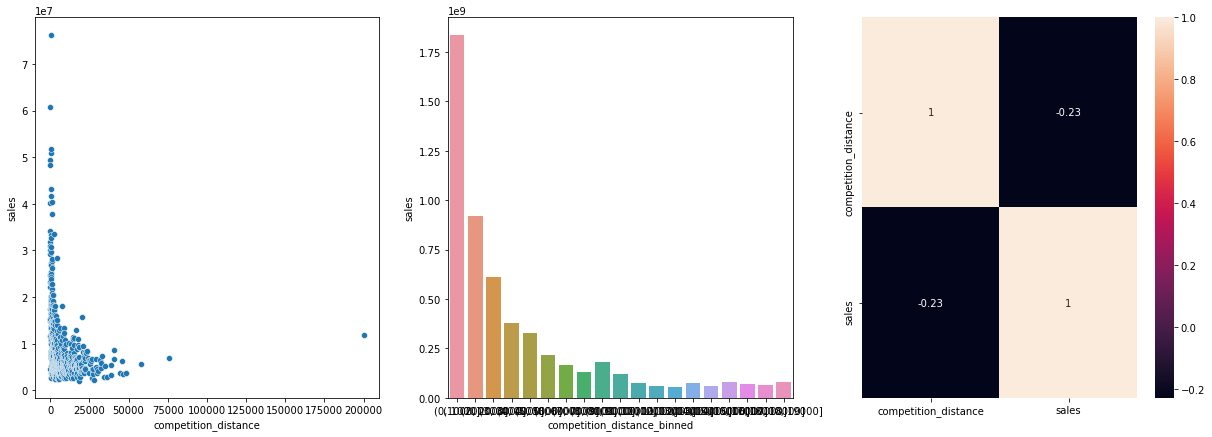

In [38]:
#Concentração de vendas está nas lojas que tem competidores mais próximos
fig = plt.figure(figsize =(21, 7))
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux1);
plt.subplot(1,3,2)
#aux1 = df4[['competition_distance','sales']].groupby(['competition_distance']).sum().reset_index()
bins = list(np.arange(0,20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
#fig = plt.figure(figsize =(15, 7))
sns.barplot(x='competition_distance_binned', y='sales',data=aux2);

plt.subplot(1,3,3)
#fig = plt.figure(figsize =(15, 7))
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSO** LOjas vendem mais no inicio das promoções, depois de um tempo de duração as vendas se reducem

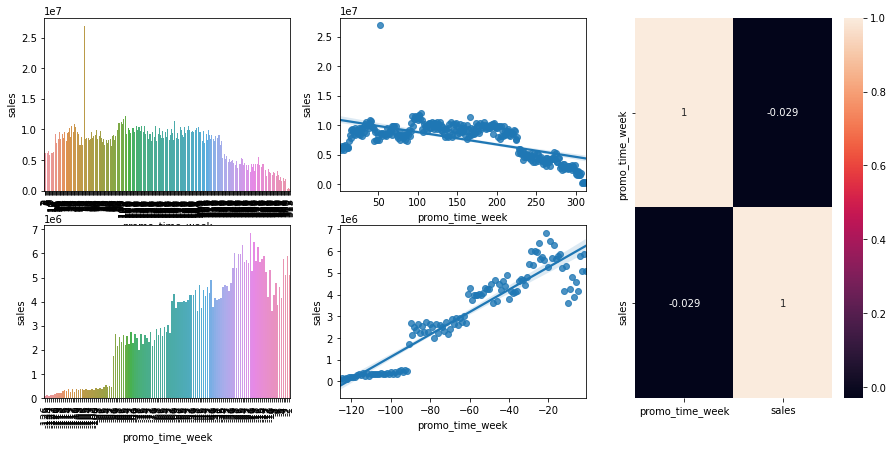

In [39]:

fig = plt.figure(figsize =(15, 7))
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3 )
#grid = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0]#promo extendida
sns.barplot(x='promo_time_week',y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales',data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0] #promo regular
sns.barplot(x='promo_time_week',y='sales',data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H6. Lojas com mais promoções consecutivas deveriam vender mais
**FALSO** Lojas com promoções consecutivas vendem menos

In [40]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


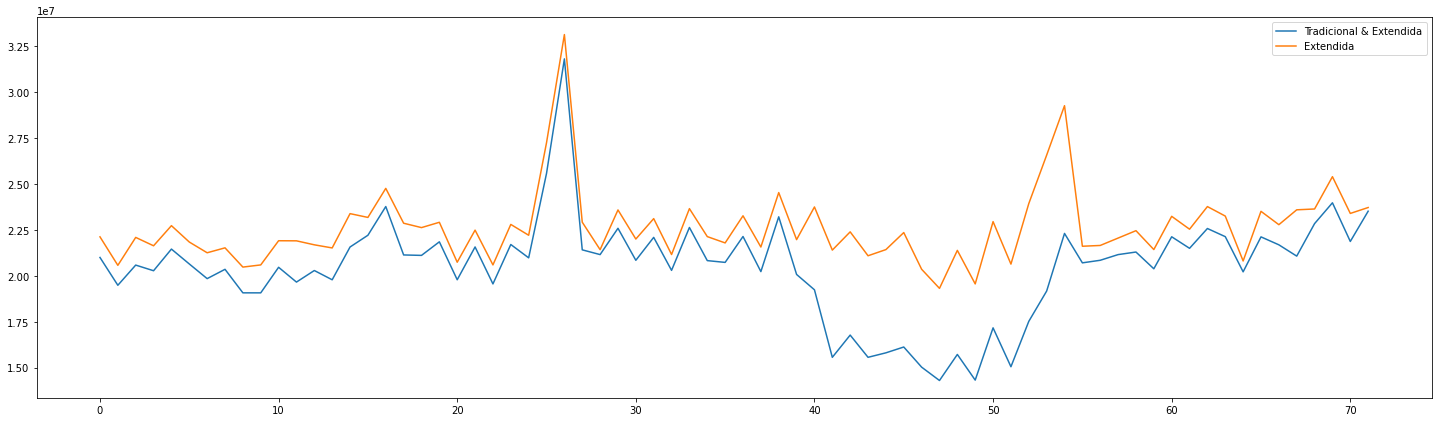

In [41]:

aux1 = df4[(df4['promo']==1)&(df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize =(25, 7))

aux2 = df4[(df4['promo']==1)&(df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax = ax)

ax.legend(labels=['Tradicional & Extendida','Extendida']);

### H7. Lojas abertas durante o peridodo de natal deveriam vender mais

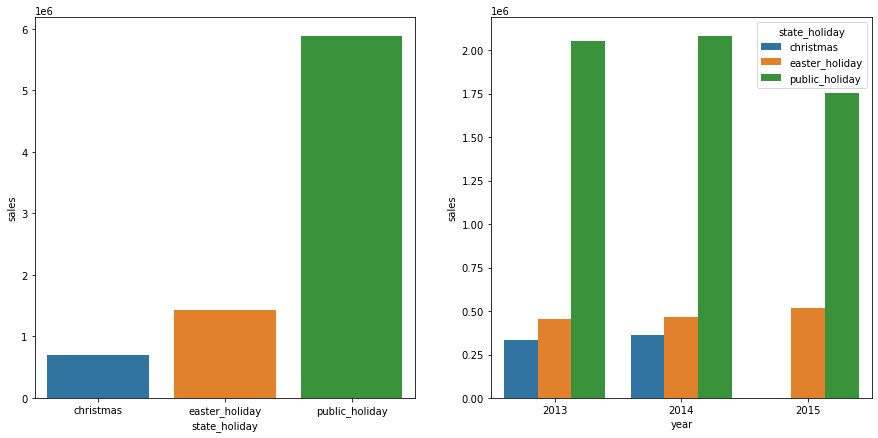

In [42]:
aux = df4[df4['state_holiday'] != 'regular_day']
fig = plt.figure(figsize =(15, 7))
plt.subplot(1,2,1)
aux1=aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales',data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux2);

### H8. Lojas deveriam vender mais ao longo dos anos

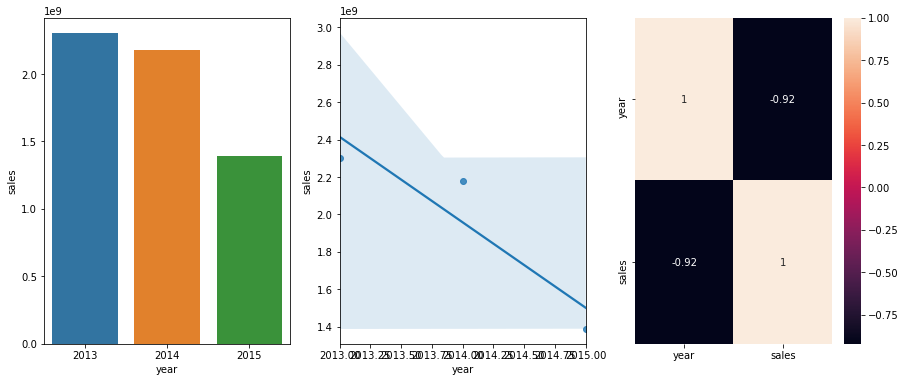

In [43]:

fig = plt.figure(figsize =(15, 6))
plt.subplot(1,3,1)
aux1=df4[['year','sales']].groupby('year').sum().reset_index()
sns.barplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H9. Lojas devem vender mais no segundo semestre do ano

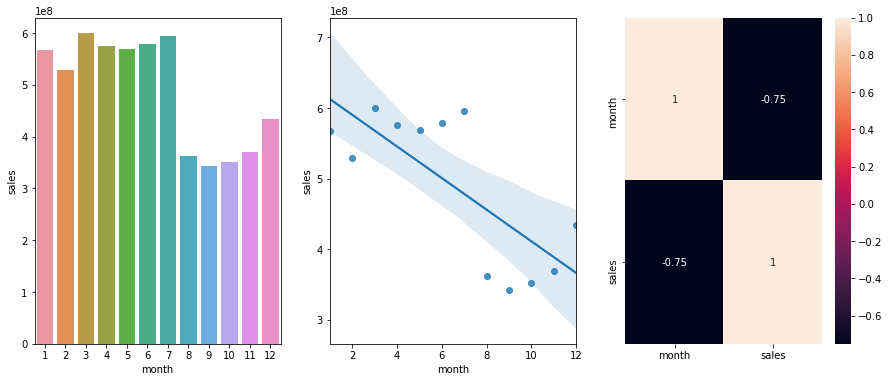

In [44]:

fig = plt.figure(figsize =(15, 6))
plt.subplot(1,3,1)
aux1=df4[['month','sales']].groupby('month').sum().reset_index()
sns.barplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês

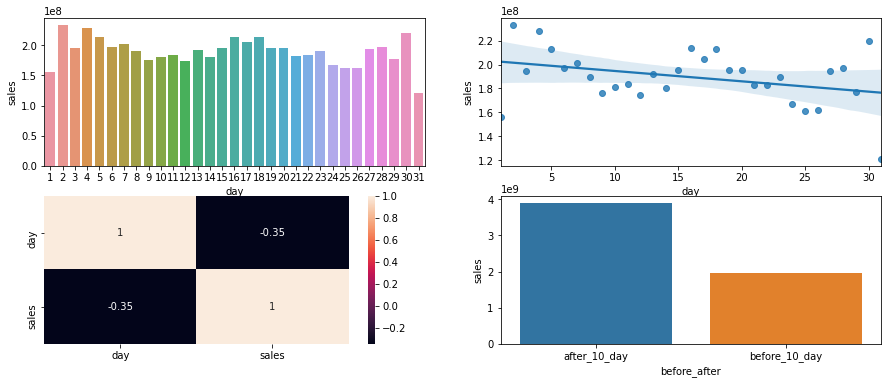

In [45]:

fig = plt.figure(figsize =(15, 6))
plt.subplot(2,2,1)
aux1=df4[['day','sales']].groupby('day').sum().reset_index()
sns.barplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);
plt.subplot(2,2,4)
aux1['before_after']=aux1['day'].apply(lambda x: 'before_10_day' if x<=10 else 'after_10_day')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after',y='sales',data=aux2);

### H11. Lojas deveriam vender menos nos finais de semana

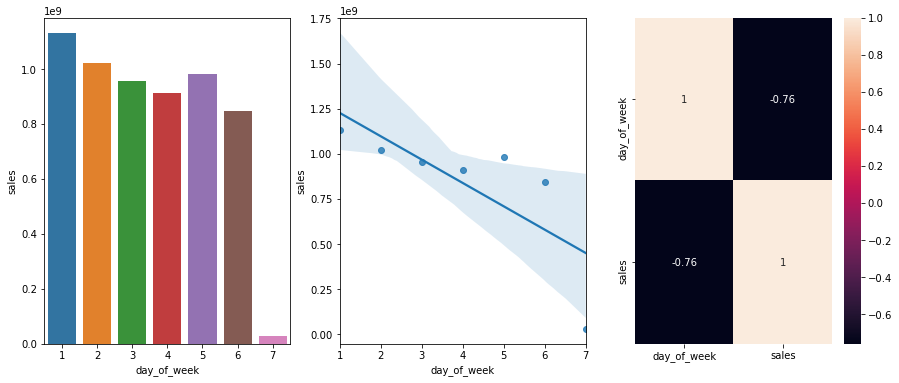

In [46]:

fig = plt.figure(figsize =(15, 6))
plt.subplot(1,3,1)
aux1=df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares

<AxesSubplot:xlabel='month', ylabel='sales'>

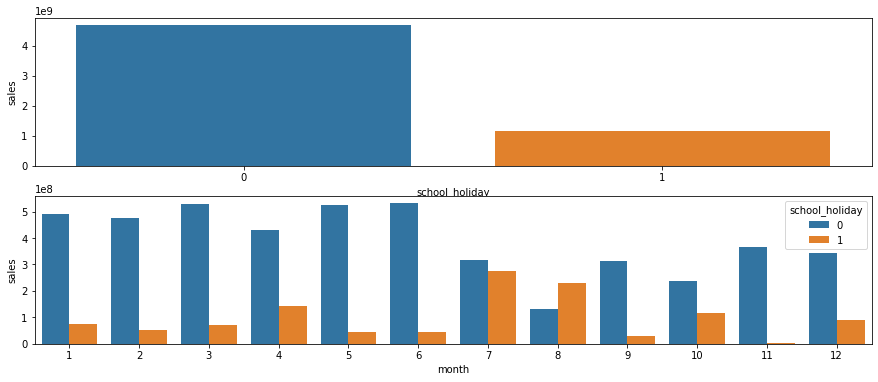

In [47]:
fig = plt.figure(figsize =(15, 6))
aux = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales',data=aux)
plt.subplot(2,1,2)
aux1 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux1)

## 4.3. Analise Multivariada

### 4.3.1. Atributos Numéricos

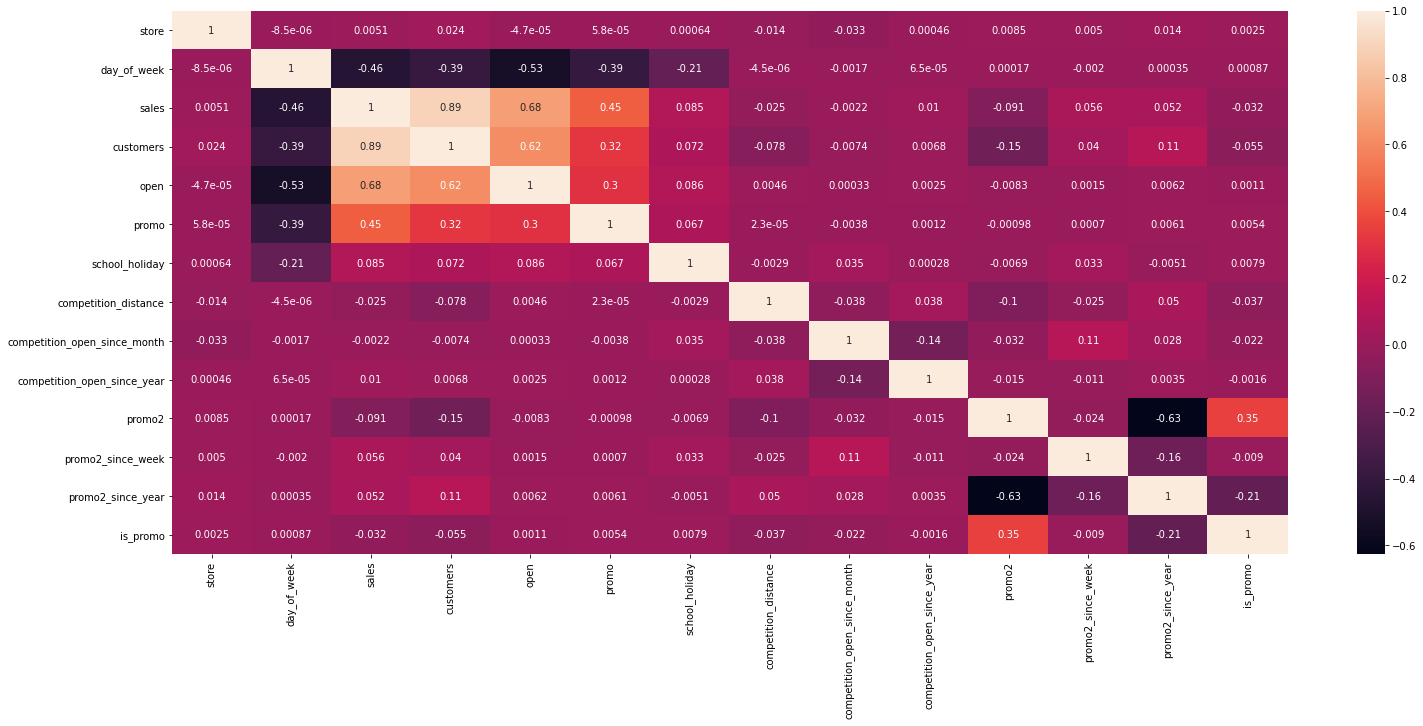

In [48]:
fig = plt.figure(figsize =(25, 10))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True);

### 4.3.2. Atributos Categóricos

In [49]:
a =df4.select_dtypes(include='object')
a.sample(10)

,state_holiday,store_type,assortment,year_week
497372,regular_day,d,extended,2014-14
439161,regular_day,d,extended,2014-22
110763,regular_day,d,basic,2015-16
549300,regular_day,a,basic,2014-08
547670,regular_day,a,basic,2014-08
255184,regular_day,a,basic,2014-49
328862,regular_day,c,extended,2014-38
998884,regular_day,a,basic,2013-02
756661,regular_day,c,extended,2013-33
418602,regular_day,a,basic,2014-24


In [50]:
## Criamos uma tabela tipo validação cruzada. Aplica tds as combinações
#cm = pd.crosstab(a['state_holiday'],a['store_type']).to_numpy()
#cm
##Comentei para criar minha função

In [51]:
#chi2
#Entrega 04 resultados. Teste baseado em Pearson, P-Valor, Grau de Liberdade, tabela de frequencia.
# No caso só vou me interessar pelo Teste, por isso [0]

In [52]:
#Chamando a função
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9],
             })

d = d.set_index(d.columns)

<AxesSubplot:>

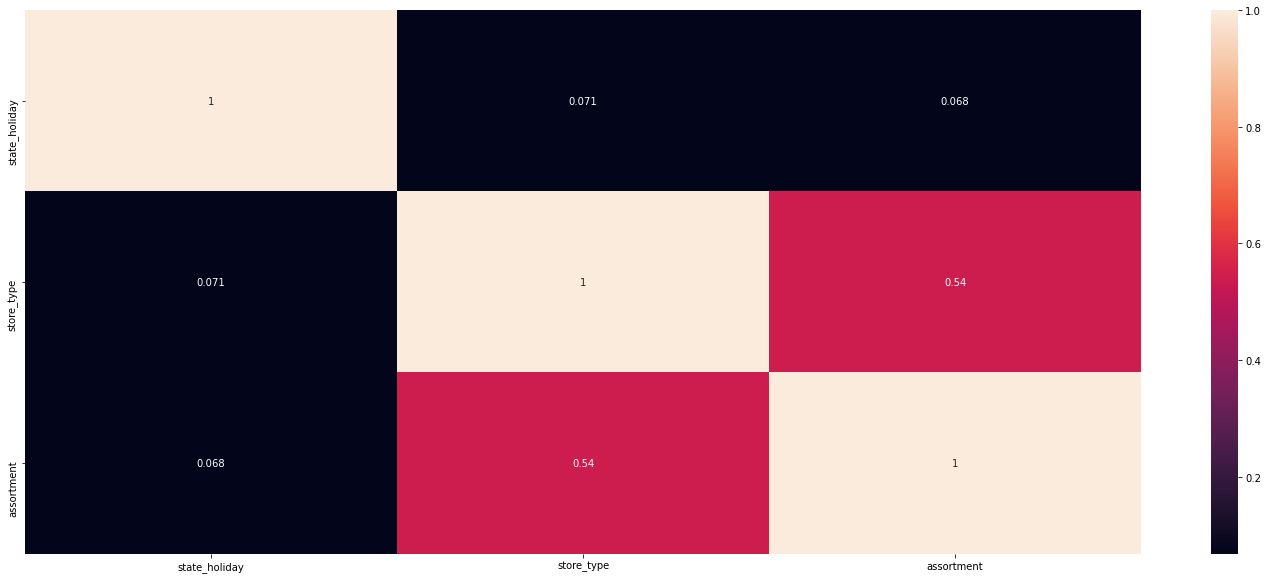

In [53]:
fig = plt.figure(figsize =(25, 10))
sns.heatmap(d,annot=True)

## 5.0 Transformação dos Dados

In [95]:
df5 = df4.copy()

### 5.1. Normalização

### 5.2. Rescaling

In [96]:
a =df5.select_dtypes(include=['int64','int32','float64'])

<AxesSubplot:xlabel='promo_time_week'>

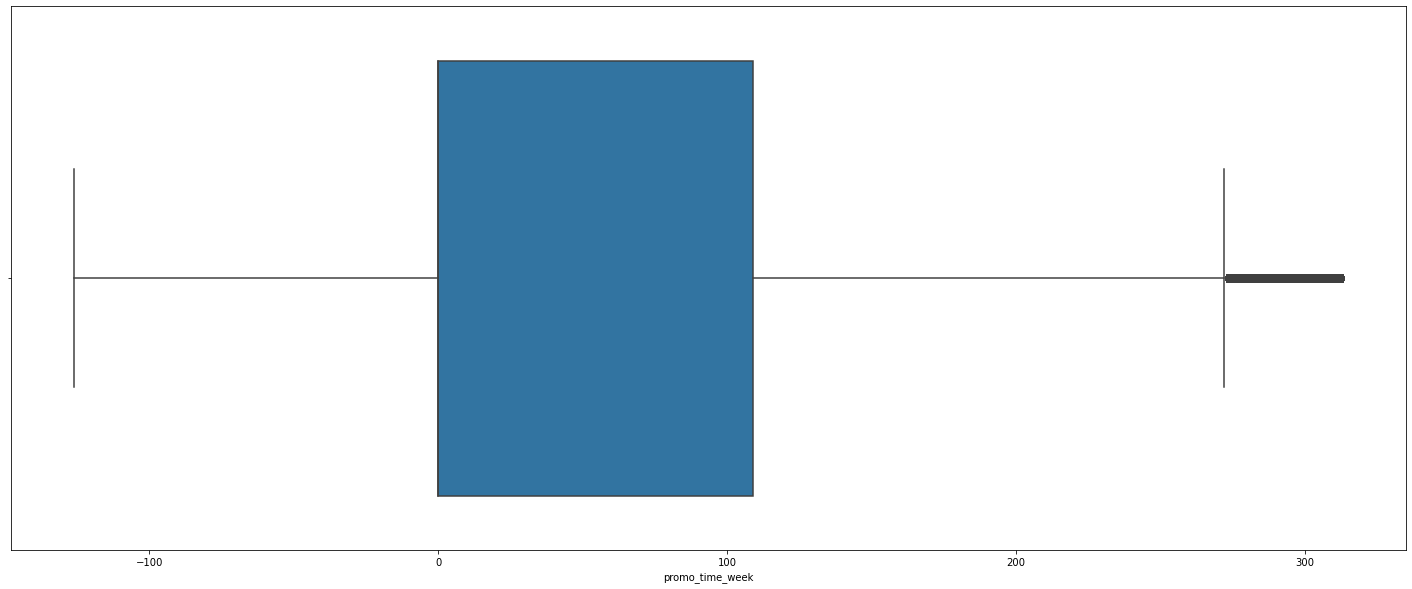

In [97]:
fig = plt.figure(figsize =(25, 10))
sns.boxplot(df5['promo_time_week'])

In [98]:
rs = RobustScaler()
mms = MinMaxScaler()

In [99]:
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
df5['year'] = mms.fit_transform(df5[['year']].values)

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

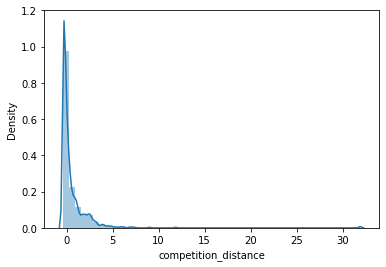

In [100]:
sns.distplot(df5['competition_distance'])

## 5.3. Tranformações

### 5.3.1. Encoding

In [101]:
#label-encoder
le = LabelEncoder()
df5['store_type']= le.fit_transform(df5['store_type'])

# State_holidays - one hot enconding
df5 = pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

# Ordinal_Encoding - porque tem um ordem
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Transformação da variável resposta

In [102]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Tranformação por Natureza

In [103]:
#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x *(2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x *(2. * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x *(2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x *(2. * np.pi/30)))

#year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x *(2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x *(2. * np.pi/52)))

#day
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi/7)))

In [104]:
df5.sample(3)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
400644,769,3,2014-07-09,9.240870,0,1,1,2,-0.240323,7,2014,1,48,2012,1,0.5,7,9,28,2014-27,2012-11-19,0.480638,0,0,0,1,-0.500000,-8.660254e-01,0.951057,-0.309017,-0.239316,-0.970942,0.433884,-0.900969
541312,208,1,2014-03-03,8.259458,1,0,2,1,-0.327419,4,2006,0,10,2014,0,0.5,3,3,10,2014-09,2014-03-03,0.287016,0,0,0,1,1.000000,6.123234e-17,0.587785,0.809017,0.935016,0.354605,0.781831,0.623490
762321,447,6,2013-08-17,8.465479,0,0,0,3,-0.132258,9,2013,0,33,2013,0,0.0,8,17,33,2013-32,2013-08-12,0.287016,0,0,0,1,-0.866025,-5.000000e-01,-0.406737,-0.913545,-0.748511,-0.663123,-0.781831,0.623490
